<a href="https://colab.research.google.com/github/TheDraguun/collabtf2.0/blob/master/Copy_of_pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pix2Pix

## Intro


In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/alpha/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This notebook demonstrates image to image translation using conditional GAN's, as described in [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004). Using this technique we can colorize black and white photos, convert google maps to google earth, etc. Here, we convert building facades to real buildings.

In example, we will use the [CMP Facade Database](http://cmp.felk.cvut.cz/~tylecr1/facade/), helpfully provided by the [Center for Machine Perception](http://cmp.felk.cvut.cz/) at the [Czech Technical University in Prague](https://www.cvut.cz/). To keep our example short, we will use a preprocessed [copy](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/) of this dataset, created by the authors of the [paper](https://arxiv.org/abs/1611.07004) above.

Each epoch takes around 58 seconds on a single P100 GPU.

Below is the output generated after training the model for 200 epochs.

![sample output_1](https://www.tensorflow.org/images/gan/pix2pix_1.png)
![sample output_2](https://www.tensorflow.org/images/gan/pix2pix_2.png)

## Import TensorFlow and other libraries

In [46]:
from __future__ import absolute_import, division, print_function

#!pip install tensorflow==1.12

#!pip show tensorflow

import tensorflow as tf

#from tensorflow.core.protobuf import config_pb2
#tf.enable_eager_execution(config=config_pb2.ConfigProto(log_device_placement=True))
tf.compat.v1.disable_eager_execution()

import os
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pprint import pprint

print('TF Version {}'.format(tf.__version__))
print('GPU Available {} {}'.format(tf.test.is_gpu_available(),tf.test.gpu_device_name()))
print("Eager:", tf.executing_eagerly())

tf.reset_default_graph()


use_tpu = False
tpu_address = ''

if 'COLAB_TPU_ADDR' not in os.environ:
  print('Not connected to a TPU runtime!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)  
  use_tpu = True
  
  from tensorflow.contrib import tpu
  from tensorflow.contrib.tpu.python.tpu import tpu_function

  
  with tf.Session(tpu_address) as sess:
    devices = sess.list_devices()
    
  print('TPU devices:')
  pprint(devices)
  
print('use TPU: ', use_tpu)
  

  
#  tf.logging.set_verbosity(tf.logging.INFO)
#generator = tf.contrib.tpu.keras_to_tpu_model(generator_,
#    strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(tpu_address)))



TF Version 1.13.1
GPU Available False 
Eager: False
TPU address is grpc://10.84.135.154:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 9309922750897261383),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 7790305502638287557),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 15955178168449271649),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 13833060778686977190),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 4640736725549212282),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 4660284063045497075),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 16520199265776108880),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 10365044015324219092),
 _DeviceAttributes(/job:tpu_worker/replica:

## graph vis

In [0]:

# Creates a graph.

a_input = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a_input')
ds = tf.data.Dataset.list_files('/content/sample_data/*.csv').shuffle(10).map(lambda x : a_input)
ds_it = ds.make_one_shot_iterator()
a = ds_it.get_next()
#a = tf.placeholder(shape=[2, 3], name='a')

b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
options = tf.RunOptions(output_partition_graphs=True)
metadata = tf.RunMetadata()
c_val = sess.run({'c': c}, options=options, run_metadata=metadata)



#print("Meta:",metadata)
#print("Graphs:", metadata.partition_graphs)

#for g in metadata.partition_graphs:
#  print("\n-----------------------------------------------------\n")
#  print(g)
#  print("-----------------------------------------------------\n")


In [0]:
from IPython.display import clear_output, Image, display, HTML

# Helper functions for TF Graph visualization
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes(""%size, 'utf-8')
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def=None, max_const_size=32):
    """Visualize TensorFlow graph."""
    
    # If no input graph is given, get the default graph
    if graph_def is None:
        graph_def = tf.get_default_graph().as_graph_def()
        
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:400px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:420px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
        
    

In [0]:
import pydot
from itertools import chain


def tf_graphs_to_dot(graph_defs):
    dot = pydot.Dot()
    dot.set('rankdir', 'TD')
    dot.set('concentrate', True)
    dot.set_node_defaults(shape='record')
    
    # dot.set('labelloc','t')
    # dot.set('label', graph_def.node[0].device)

    for g in graph_defs:
      
      for c_node in g.node:
          node = pydot.Node(c_node.name, label=(c_node.name+' '+c_node.op))#c_node.device)
          dot.add_node(node)   
          for c_input in c_node.input:
              dot.add_edge(pydot.Edge(c_input, c_node.name))

      #all_ops = in_graph.get_operations()

      #all_tens_dict = {k: i for i,k in enumerate(set(chain(*[c_op.outputs for c_op in all_ops])))}
      #for c_node in all_tens_dict.keys():
      #    node = pydot.Node(c_node.name)#, label=label)
      #    dot.add_node(node)
      #for c_op in all_ops:
      #    for c_output in c_op.outputs:
      #        for c_input in c_op.inputs:
      #            dot.add_edge(pydot.Edge(c_input.name, c_output.name))
    return dot
  
  
  
  
  
from IPython.display import Image, display

def viewPydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)
  
  
from IPython.display import SVG

def show_dot_graph(g=None):
    if g is None:
        g = [tf.get_default_graph().as_graph_def()]
    pdot = tf_graphs_to_dot(g)
    viewPydot(pdot)
  
  
  
#show_dot_graph(metadata.partition_graphs)





from google.protobuf import text_format
graph_def = tf.GraphDef()
for g in metadata.partition_graphs:
  s = text_format.MessageToString(g)
  text_format.Merge(s, graph_def)
  

s = {}
r = []
for n in graph_def.node:
  if n.op == '_Send':
    s[n.experimental_debug_info.original_node_names[0]] = n
  elif n.op == '_Recv':
    r.append(n)
    
for n_r in r:
  n_s = s.get(n_r.experimental_debug_info.original_node_names[0])
  if not n_s == None:
     n_r.input.append(n_s.name) 

#print(graph_def)  

#show_dot_graph([graph_def])
  
#show_graph(graph_def)

In [0]:
import functools
def eager(func):
    @functools.wraps(func)
    def eager_func(*args, **kwargs):
      with tf.Session() as sess:
         sess.run(tf.contrib.eager.py_func(func, inp=list(kwargs.values()), Tout=[]))
    return eager_func

## Load the dataset

You can download this dataset and similar datasets from [here](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets). As mentioned in the [paper](https://arxiv.org/abs/1611.07004) we apply random jittering and mirroring to the training dataset.
* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [7]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL, 
                                      extract=True,
                                      cache_dir="/content")

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

print(PATH)



/content/datasets/facades/


In [8]:
if use_tpu:

  # GCS.
  project_id = 'norse-blade-237717'
  bucket_name = 'colab-mk' 
  
  # Authenticate to GCS.
  from google.colab import auth
  auth.authenticate_user()

  # Create the service client.
  from googleapiclient.discovery import build
  gcs_service = build('storage', 'v1')
  
  
  if not os.path.exists('/content/gcs.json'):
    !echo "deb http://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | tee /etc/apt/sources.list.d/gcsfuse.list
    !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -

    !apt-get update
    !apt-get install gcsfuse

    !mkdir -p /content/gcs 
    !chmod 777 /content/gcs


    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
      print('Uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
      with open('/content/gcs.json', 'wb') as f:
        f.write(uploaded[fn])
  
  
  !fusermount -u  /content/gcs
  #!gcloud auth application-default login
  #!gcloud config set project {project_id}
  #!gcsfuse -o allow_other -o async --gid 0 --uid 0 --file-mode 777 --dir-mode 777 --key-file /content/gcs.json colab-mk /content/gcs
  !gcsfuse -o allow_other colab-mk /content/gcs
  
  #!mkdir /content/gcs/test
  #with open('/content/gcs/test/text.txt', 'w') as f:
  #  f.write('test')
  
  if not os.path.isdir('/content/gcs/datasets/facades'):
    !mkdir /content/gcs/datasets
    !mkdir /content/gcs/datasets/facades
    #!cp -TvRf /content/datasets/facades/ /content/gcs/datasets/facades/

    !gsutil rsync -r /content/datasets/facades/ gs://{bucket-name}/datasets/facades/

  

    
  #import distutils.dir_util
  #distutils.dir_util.copy_tree('/content/datasets/facades/', '/content/gcs/datasets/facades/')
    


Using mount point: /content/gcs
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.


In [0]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [0]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)
  
  s = tf.shape(image)
  h = s[0]
  w = s[1]
  
  image = tf.reshape(image, [h, w, 3])

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  

  return input_image, real_image

Tensor("Cast_6:0", shape=(256, 256, 3), dtype=float32)


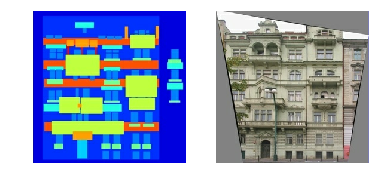

In [61]:

inp, re = load(PATH+'train/100.jpg')
print(inp)  

@eager
def test_load():
  global inp, re
  inp, re = load(PATH+'train/100.jpg')
  plt.figure(figsize=(6, 6))
  plt.subplot(1, 2, 1)
  plt.imshow(inp/255.0)
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.imshow(re/255.0)
  plt.axis('off')

test_load()




In [0]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize_images(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize_images(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
  return input_image, real_image

In [0]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
  
  return cropped_image[0], cropped_image[1]

In [0]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1
  
  return input_image, real_image

In [0]:
#@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  # random mirroring
  condition = tf.random.uniform(()) > 0.5
  # if (condition):
  #  input_image = tf.image.flip_left_right(input_image)
  #  real_image = tf.image.flip_left_right(real_image)
  input_image = tf.cond(condition, lambda: input_image, lambda: tf.image.flip_left_right(input_image)) 
  real_image = tf.cond(condition, lambda: real_image, lambda: tf.image.flip_left_right(real_image))   
    
  return input_image, real_image

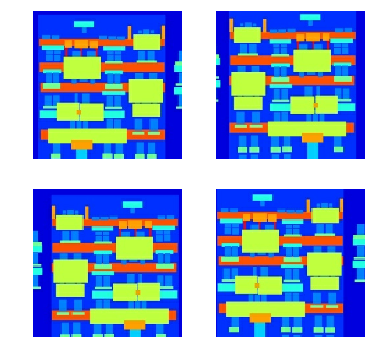

In [16]:
# As you can see in the images below
# that they are going through random jittering
# Random jittering as described in the paper is to
# 1. Resize an image to bigger height and width
# 2. Randomnly crop to the original size
# 3. Randomnly flip the image horizontally 


@eager
def test_jitter():
  plt.figure(figsize=(6, 6))
  for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)  
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
  plt.show()
  
test_jitter()

In [0]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return (input_image), (real_image, tf.fill([30,30],1.0))

In [0]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH) 
  input_image, real_image = normalize(input_image, real_image)
  
  return input_image, real_image

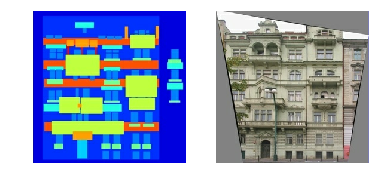

In [19]:


@eager
def test_load_image_train():
  inp, re = load(PATH+'train/100.jpg')
  plt.figure(figsize=(6, 6))
  plt.subplot(1, 2, 1)
  plt.imshow(inp/255.0)
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.imshow(re/255.0)
  plt.axis('off')
  
test_load_image_train()

## Input Pipeline

In [0]:
DS_PATH = PATH
if use_tpu:
  DS_PATH='gs://{}/datasets/facades/'.format(bucket_name)

In [0]:
def create_train_dataset():
  train_dataset = tf.data.Dataset.list_files(DS_PATH+'train/*.jpg')
  train_dataset = train_dataset.shuffle(BUFFER_SIZE)
  train_dataset = train_dataset.map(load_image_train) #,num_parallel_calls=tf.data.experimental.AUTOTUNE)
  train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
  train_dataset = train_dataset.repeat().prefetch(1)
  return train_dataset;

In [0]:
def create_test_dataset():
  test_dataset = tf.data.Dataset.list_files(DS_PATH+'test/1*.jpg')
  # shuffling so that for every epoch a different image is generated 
  # to predict and display the progress of our model.
  test_dataset = test_dataset.shuffle(BUFFER_SIZE)
  test_dataset = test_dataset.map(load_image_test)
  test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
  #test_dataset = test_dataset.repeat()
  return test_dataset;

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).
 
    

In [0]:
OUTPUT_CHANNELS = 3

In [0]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
    
  result.add(tf.keras.layers.LeakyReLU())

  return result

In [25]:
@eager
def test_down():
  global down_result
  down_model = downsample(3, 4)
  down_result = down_model(tf.expand_dims(inp, 0))
  print (down_result.shape)
  
test_down()

Instructions for updating:
Colocations handled automatically by placer.
(1, 128, 128, 3)


In [0]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same', 
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())
  
  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [27]:
@eager
def test_up():
  global down_result
  up_model = upsample(3, 4)
  up_result = up_model(down_result)
  print (up_result.shape)
  
test_up()

(1, 256, 256, 3)


In [0]:
def Generator(name="Generator"):
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, 
                                         strides=2, 
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate() 

  inputs = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,3], batch_size=BATCH_SIZE, name="generator_condition_input")
  x = inputs
  
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    #x = concat([x, skip])
    x = tf.keras.layers.concatenate([x, skip]) 

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x , name=name )

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
generator_condition_input (Inpu (1, 256, 256, 3)     0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (1, 128, 128, 64)    3072        generator_condition_input[0][0]  
__________________________________________________________________________________________________
sequential_1 (Sequential)       (1, 64, 64, 128)     131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (1, 32, 32, 256)     525312      sequential_1[0][0]          

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


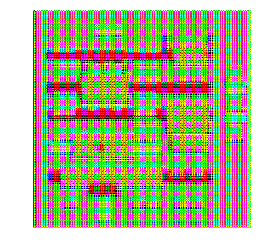

In [29]:
@eager
def test_generator():
  global gen_output
  generator = Generator(name="G")
  generator.summary()
  gen_output = generator(inp[tf.newaxis,...], training=False)
  plt.imshow(gen_output[0,...]*0.5+0.5)
  plt.axis('off')
  
test_generator()  

## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake. 
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [0]:
def Discriminator( name="Discriminator"):
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 3], batch_size=BATCH_SIZE, name="discriminator_condition_input")
  tar = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 3], batch_size=BATCH_SIZE, name="discriminator_target_input")
  
  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)
  
  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, 
                                kernel_initializer=initializer, 
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
  
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv) 

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
  
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
  
  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
  
  return tf.keras.Model(inputs=[inp, tar], outputs=last, name=name )


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
discriminator_condition_input ( (1, 256, 256, 3)     0                                            
__________________________________________________________________________________________________
discriminator_target_input (Inp (1, 256, 256, 3)     0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (1, 256, 256, 6)     0           discriminator_condition_input[0][
                                                                 discriminator_target_input[0][0] 
__________________________________________________________________________________________________
sequential (Sequential)         (1, 128, 128, 64)    6144        concatenate[0][0]                
__________

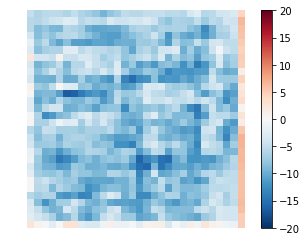

In [31]:
@eager
def test_discriminator():
  global gen_output
  discriminator = Discriminator(name="D")
  discriminator.summary()
  disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
  plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
  plt.colorbar()
  plt.axis('off')
  
test_discriminator()

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

## Define the loss functions and the optimizer

* **Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss
  
* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

In [0]:
LAMBDA = 100

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [0]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  
  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [0]:

def log_eps(i):
    return tf.log(tf.clip_by_value(i,0,1e11) + 1e-11)

        
#      dloss = - tf.reduce_mean(log_eps(1-disc_gen_output) 
#                               + .1 * log_eps(1-disc_real_output) 
#                               + .9 * log_eps(disc_real_output))
#
#      gloss = - tf.reduce_mean(log_eps(disc_gen_output))

### Checkpoints (Object-based saving)

## Training

* We start by iterating over the dataset
* The generator gets the input image and we get a generated output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* This entire procedure is shown in the images below.

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/images/dis.png?raw=1)


---


![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/images/gen.png?raw=1)

## Generate Images

* After training, its time to generate some images!
* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output we expect.
* Last step is to plot the predictions and **voila!**

In [0]:
EPOCHS = 4
steps_per_epoch = 40//BATCH_SIZE

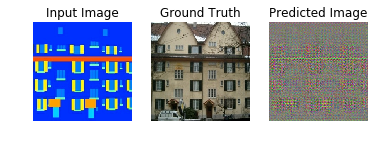

In [38]:
#@eager
def generate_images(model, inp, tar):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get 
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(inp, training=True)
  
  sess= tf.get_default_session()
  prediction = sess.run(prediction)
  
  
  plt.figure(figsize=(6,6))

  display_list = [inp[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
  
  
  
  
dataset=create_train_dataset()
generator = Generator()

iterator = dataset.make_initializable_iterator()
get_next = iterator.get_next()

sess = tf.Session()

with sess.as_default():

  sess.run([iterator.initializer, tf.global_variables_initializer()])
  
  (input_image), (target, _) = sess.run(get_next)
  #inp = input_image[0,:,:,:]
  #tar = target[0,:,:,:]
  generate_images(model=generator, inp=input_image, tar=target)
  
sess.close()

In [39]:
if use_tpu:
  
  tf.reset_default_graph()
  tf.keras.backend.clear_session()
  
  tpu_function.get_tpu_context().set_number_of_shards(None)

  def add_op(x, y):
    return x + y

  x = tf.placeholder(tf.float32, [10,])
  y = tf.placeholder(tf.float32, [10,])
  tpu_ops = tpu.rewrite(add_op, [x, y])

  try:
    sess = tf.Session(tpu_address)
    print('Initializing...')
    sess.run(tf.contrib.tpu.initialize_system())
    print('Running ops')
    print(sess.run(tpu_ops, {x: np.arange(10), y: np.arange(10)}))
  finally:
    sess.run(tf.contrib.tpu.shutdown_system())
    sess.close()

Initializing...
Running ops
[array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.], dtype=float32)]


In [0]:




def clean_init_for_training():

  global train_dataset
  global test_dataset
  global generator
  global discriminator 
  global generator_optimizer
  global discriminator_optimizer
  global checkpoint_dir
  global checkpoint_prefix
  global checkpoint
  global sess
  
  
  tpu_function.get_tpu_context().set_number_of_shards(None)
  #close sess, shutdown tpu
  
  
  tf.reset_default_graph()
  tf.keras.backend.clear_session()
  
 # if not use_tpu:
    #sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
  sess = tf.Session()
 # else:
  #  sess = tf.Session(tpu_address)


  tf.keras.backend.set_learning_phase(1)
  print ('K.learning_phase: ',tf.keras.backend.learning_phase())
  
  tf.keras.backend.set_session(sess)
  
  train_dataset=create_train_dataset()    
  test_dataset=create_test_dataset()


  generator = Generator()
  discriminator = Discriminator()

  
  #generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
  #discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
  generator_optimizer = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.2, beta2=0.999, epsilon=1e-08, name="generator_optimizer")
  discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.2, beta2=0.999, epsilon=1e-08, name="discriminator_optimizer")


  
  
  if use_tpu & False:

    #tpu_function.get_tpu_context().set_number_of_shards(8)
    
    generator = tpu.keras_to_tpu_model(generator,
                                                  strategy=tf.contrib.tpu.TPUDistributionStrategy(
                                                      tf.contrib.cluster_resolver.TPUClusterResolver(tpu_address)))
    discriminator = tpu.keras_to_tpu_model(discriminator,
                                                      strategy=tf.contrib.tpu.TPUDistributionStrategy(
                                                          tf.contrib.cluster_resolver.TPUClusterResolver(tpu_address)))
    
    generator_optimizer = tpu.CrossShardOptimizer(generator_optimizer)
    discriminator_optimizer = tpu.CrossShardOptimizer(discriminator_optimizer)


  
  checkpoint_dir = './training_checkpoints'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

  checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                   discriminator_optimizer=discriminator_optimizer,
                                   generator=generator,
                                   discriminator=discriminator)
  
  

  
  
  
  

In [0]:


def train_step_(input_image, target):
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  update_wg = generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  update_wd = discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables),
                                                     global_step=tf.train.get_global_step())
  
  return [update_wg, update_wd]


#@tf.function
@eager
def train_step(input_image, target):
  train_step_(input_image, target)
  
  
  
def train(dataset, epochs):  
  
  if tf.executing_eagerly():
    print("eager")
    iterator = dataset.make_one_shot_iterator()    
  else:
    print("static")
    
    iterator = dataset.make_initializable_iterator()
    get_next = iterator.get_next()
    (input_image), (target, _) = get_next
    train_op = train_step_(input_image, target)
      
    with sess.as_default():
      
      if use_tpu:
        sess.run(tpu.initialize_system())
      
      sess.run([iterator.initializer, tf.global_variables_initializer()])
      
      (input_image), (target, _) = sess.run(get_next)
      generate_images(model=generator, inp=input_image, tar=target)

      for epoch in range(epochs):

        start = time.time()
        print('Epoch', epoch)
        #progbar = tf.keras.utils.Progbar(target=steps_per_epoch, stateful_metrics='loss')

        for step in range(steps_per_epoch):  
            if tf.executing_eagerly():
              input_image, target = iterator.get_next()
              train_step(input_image, target)
            else:
              sess.run(train_op)

        #clear_output(wait=True)
        (input_image), (target, _) = sess.run(get_next)
        generate_images(model=generator, inp=input_image, tar=target)

        # saving (checkpoint) the model every 20 epochs
        #if (epoch + 1) % 20 == 0:
        #  checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
        
        
    if use_tpu:
      sess.run(tpu.shutdown_system())
    sess.close()

if not use_tpu: 
  clean_init_for_training()
  train(train_dataset, EPOCHS)

In [0]:

  
MODEL_DIR = '/content/model/' 

tf.test.gpu_device_name()

def trainE(dataset, epochs):  

  def model_fn(features, labels, mode):
    
    global generator
    
    
    input_image = features
    generator=Generator()
    
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        output_image = generator(input_image, training=True)
        predictions = {
           'input': input_image,
           'output': output_image
        }
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    
    (target_image, label) = labels
    discriminator=Discriminator()
    

    #generator_optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    #discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=0.0005)
    
    generator_optimizer = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.2, beta2=0.999, epsilon=1e-08, name="generator_optimizer")
    discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.2, beta2=0.999, epsilon=1e-08, name="discriminator_optimizer")
    

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
      gen_output = generator(input_image, training=True)

      disc_real_output = discriminator([input_image, target_image], training=True)
      disc_generated_output = discriminator([input_image, gen_output], training=True)

      gen_loss = generator_loss(disc_generated_output, gen_output, target_image)
      disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    update_wg = generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    update_wd = discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables),
                                                        global_step=tf.train.get_global_step())

  
    
    

    gen_loss = generator_loss(disc_generated_output, gen_output, target_image)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    


    update_wg = generator_optimizer.minimize(gen_loss, var_list=generator.trainable_variables)
    update_wd = discriminator_optimizer.minimize(disc_loss, var_list=discriminator.trainable_variables, 
                                                 global_step=tf.train.get_global_step())
    

    
    
    train_op = tf.group([update_wg, update_wd])
    
    loss = gen_loss + disc_loss
    
    
    
    return tf.estimator.EstimatorSpec(mode=mode, train_op=train_op, loss=loss)

  
  
  class ECheckpointSaverListener(tf.estimator.CheckpointSaverListener):
    def begin(self):
      # You can add ops to the graph here.
      print('E Starting the session.')
      #self.your_tensor = ...

    def before_save(self, session, global_step_value):
      print('E About to write a checkpoint')

    def after_save(self, session, global_step_value):
      print('E Done writing checkpoint.')
      #if decided_to_stop_training():
      #  return True

    def end(self, session, global_step_value):
      print('E Done with the session.')


  listener = ECheckpointSaverListener()
  
  
  
  print('steps per epoch: ', steps_per_epoch, ' batch size: ', BATCH_SIZE, ' epochs: ', EPOCHS) 
  
  run_config = tf.estimator.RunConfig(
      save_checkpoints_steps=20*steps_per_epoch,
      save_summary_steps=20*steps_per_epoch,
      log_step_count_steps=steps_per_epoch,
      model_dir=MODEL_DIR
  )


  estimator = tf.estimator.Estimator(
      model_fn = model_fn,
      config = run_config
  )


  print('------------')

  pred = list(estimator.predict(input_fn=create_test_dataset))
  plt.figure(figsize=(6,6))
  display_list = [pred[0]['input'], pred[0]['output']]
  title = ['Input Image', 'Predicted Image']
  for i in range(2):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

  for epoch in range(epochs):

    start = time.time()
    print('Epoch', epoch)

    estimator.train(input_fn=create_train_dataset, steps=steps_per_epoch, saving_listeners=[listener])
    print('------------')
    pred = list(estimator.predict(input_fn=create_test_dataset))
    plt.figure(figsize=(6,6))
    display_list = [pred[0]['input'], pred[0]['output']]
    title = ['Input Image', 'Predicted Image']
    for i in range(2):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    plt.show()

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))


if not use_tpu: 

  import shutil
  shutil.rmtree('/content/model', ignore_errors=True)    
  clean_init_for_training()

  trainE(train_dataset, EPOCHS)  





In [67]:

MODEL_DIR = '/content/model/' 
if use_tpu:
  MODEL_DIR = 'gs://{}/model/'.format(bucket_name)
  BATCH_SIZE = 8


  
  
  
def trainE(dataset, epochs):  

  def input_fn_train(params):
    return create_train_dataset()
  
  def input_fn_predict(params):
    return create_test_dataset()
  
  def model_fn(features, labels, mode, params):
    
    global generator
    
    
    input_image = features
    generator=Generator()
    
        
    from tensorflow.python.keras._impl.keras.estimator import _clone_and_build_model
    from tensorflow.python.keras._impl.keras import models

      
    custom_objects=None
    
    #generator = _clone_and_build_model(mode, generator, custom_objects, features, labels)
    #predictions = dict(zip(model.output_names, model.outputs))


    
    if mode == tf.estimator.ModeKeys.PREDICT:
        output_image = generator(input_image, training=True)
        predictions = {
           'input': input_image,
           'output': output_image
        }
        return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, predictions=predictions)
    
    
    (target_image, label) = labels
    
    
    discriminator=Discriminator()
    

    #generator_optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    #discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=0.0005)
    
    generator_optimizer = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.2, beta2=0.999, epsilon=1e-08, name="generator_optimizer")
    discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.2, beta2=0.999, epsilon=1e-08, name="discriminator_optimizer")
    
    if use_tpu:
      generator_optimizer = tpu.CrossShardOptimizer(generator_optimizer)
      discriminator_optimizer = tpu.CrossShardOptimizer(discriminator_optimizer)

    
    

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
      gen_output = generator(input_image, training=True)

      disc_real_output = discriminator([input_image, target_image], training=True)
      disc_generated_output = discriminator([input_image, gen_output], training=True)

      gen_loss = generator_loss(disc_generated_output, gen_output, target_image)
      disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    update_wg = generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    update_wd = discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables),
                                                        global_step=tf.train.get_global_step())

  
    
    

    gen_loss = generator_loss(disc_generated_output, gen_output, target_image)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    


    update_wg = generator_optimizer.minimize(gen_loss, var_list=generator.trainable_variables)
    update_wd = discriminator_optimizer.minimize(disc_loss, var_list=discriminator.trainable_variables, 
                                                 global_step=tf.train.get_global_step())
    

    
    
    train_op = tf.group([update_wg, update_wd])
    
    loss = gen_loss + disc_loss
    
    
    
    return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, train_op=train_op, loss=loss)

  
  
  class ECheckpointSaverListener(tf.estimator.CheckpointSaverListener):
    def begin(self):
      # You can add ops to the graph here.
      print('E Starting the session.')
      #self.your_tensor = ...

    def before_save(self, session, global_step_value):
      print('E About to write a checkpoint')

    def after_save(self, session, global_step_value):
      print('E Done writing checkpoint.')
      #if decided_to_stop_training():
      #  return True

    def end(self, session, global_step_value):
      print('E Done with the session.')


  listener = ECheckpointSaverListener()
  
  
  
  print('steps per epoch: ', steps_per_epoch, ' batch size: ', BATCH_SIZE, ' epochs: ', EPOCHS) 
  
  tpu_config = tf.contrib.tpu.TPUConfig(num_shards=8, iterations_per_loop=1)
  

  
  run_config =  tf.contrib.tpu.RunConfig(
      save_checkpoints_steps=20*steps_per_epoch,
      save_summary_steps=20*steps_per_epoch,
      log_step_count_steps=steps_per_epoch,
      model_dir=MODEL_DIR,
      master=tpu_address,
      tpu_config=tpu_config
  )


  estimator = tf.contrib.tpu.TPUEstimator(
      use_tpu=use_tpu,
      model_fn=model_fn,
      train_batch_size=BATCH_SIZE,
      predict_batch_size=BATCH_SIZE,
      config=run_config
  )


  print('------------')

  pred = list(estimator.predict(input_fn=input_fn_predict))
  plt.figure(figsize=(6,6))
  display_list = [pred[0]['input'], pred[0]['output']]
  title = ['Input Image', 'Predicted Image']
  for i in range(2):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

  for epoch in range(epochs):

    start = time.time()
    print('Epoch', epoch)

    estimator.train(input_fn=input_fn_train, steps=steps_per_epoch, saving_listeners=[listener])
    
    print('------------')
    pred = list(estimator.predict(input_fn=input_fn_predict))
    plt.figure(figsize=(6,6))
    display_list = [pred[0]['input'], pred[0]['output']]
    title = ['Input Image', 'Predicted Image']
    for i in range(2):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    plt.show()

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))


  
import shutil
shutil.rmtree('/content/model', ignore_errors=True)    
clean_init_for_training()


trainE(train_dataset, EPOCHS)  





K.learning_phase:  1
steps per epoch:  40  batch size:  8  epochs:  4
INFO:tensorflow:Using config: {'_model_dir': 'gs://colab-mk/model/', '_tf_random_seed': None, '_save_summary_steps': 800, '_save_checkpoints_steps': 800, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa62997a668>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.84.135.154:8470', '_evaluation_master': 'grpc://10.84.135.154:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1, num_sh

ModuleNotFoundError: ignored

In [0]:
input("Press Enter to continue...")

In [0]:
clean_init_for_training()




def train_op(get_next):
    
    with tf.name_scope("train_op"):

      (input_image), (target, label) = get_next

      #inp = input_image
      #tar = target
      #gen_output = generator(inp, training=True)
      #disc_generated_output = discriminator([inp, gen_output], training=True)
      #disc_real_output = discriminator([inp, tar], training=True)

      inp = tf.keras.layers.InputLayer(name='train_input_image', input_tensor=input_image)
      tar = tf.keras.layers.InputLayer(name='train_target_image', input_tensor=target)#, input_shape=[IMG_WIDTH, IMG_HEIGHT, 3], batch_size=BATCH_SIZE)
      gen_output = generator(inp.output, training=True)
      disc_generated_output = discriminator([inp.output, gen_output], training=True)
      disc_real_output = discriminator([inp.output, tar.output], training=True)

      gen_loss = generator_loss(disc_generated_output, gen_output, target)
      disc_loss = discriminator_loss(disc_real_output, disc_generated_output)     

      grad_loss_wd = discriminator_optimizer.compute_gradients(disc_loss, discriminator.trainable_weights)
      update_wd = discriminator_optimizer.apply_gradients(grad_loss_wd)

      grad_loss_wg = generator_optimizer.compute_gradients(gen_loss, generator.trainable_weights)
      update_wg = generator_optimizer.apply_gradients(grad_loss_wg)
      
      train_step = [update_wd, update_wg]
      losses = [disc_loss, gen_loss]
      data = [input_image, target, gen_output]#, disc_gen_output, disc_real_output]

    return train_step, losses, data


def trainX(dataset, epochs):  

  start = time.time()
  
  iterator = dataset.make_initializable_iterator()
  get_next = iterator.get_next()
  
  train_step, losses, data = train_op(get_next)
  
  with sess.as_default():
  
    sess.run([iterator.initializer, tf.global_variables_initializer()])
    
    print ('Time taken for startup is {} sec\n'.format(time.time()-start))

    (input_image), (target, _) = sess.run(get_next)
    generate_images(model=generator, inp=input_image, tar=target)
    

    for epoch in range(epochs):

      start = time.time()
      print('Epoch', epoch)
      #progbar = tf.keras.utils.Progbar(target=steps_per_epoch, stateful_metrics='loss')

      for step in range(steps_per_epoch):  
        start_s = time.time()
        train_result, loss_values, images = sess.run([train_step, losses, data])
        #print ('Time taken for  step {} is {} sec'.format(step + 1,time.time()-start_s))
        #print ('losses: ', loss_values)#, " o: ", data[3], data[4])


      print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
      
      
      (input_image), (target, _) = sess.run(get_next)
      #inp = input_image[0,:,:,:]
      #tar = target[0,:,:,:]
      generate_images(model=generator, inp=input_image, tar=target)
      
      # saving (checkpoint) the model every 20 epochs
      #if (epoch + 1) % 20 == 0:
      #  checkpoint.save(file_prefix = checkpoint_prefix, session=sess)
      
  sess.close()


  
  
  
trainX(train_dataset, EPOCHS)

#show_graph()



In [0]:
clean_init_for_training()


def trainA(dataset, epochs):                   
  
  generator.trainable = True
  generator.compile(optimizer=generator_optimizer, loss=['mae'])
  
  dataset_iterator = dataset.make_initializable_iterator()
  get_next = dataset_iterator.get_next()

  with sess.as_default():

    sess.run(dataset_iterator.initializer)
    sess.run(tf.global_variables_initializer())
    
    (input_image), (target) = sess.run(get_next)
    generate_images(model=generator, inp=input_image, tar=target)
    
    for epoch in range(epochs):

      start = time.time()
      print('Epoch', epoch)

      for step in range(steps_per_epoch):  
        
        generator.train_on_batch(dataset)

      print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

      (input_image), (target) = sess.run(get_next)
      generate_images(model=generator, inp=input_image, tar=target)

  sess.close()
    



trainA(test_dataset, EPOCHS)

#show_graph()



In [0]:
POOL_SIZE=16


def save_jpg(image, filepath):
  image = tf.cast((image*0.5+0.5)*255, dtype=np.uint8)
  image_data = tf.image.encode_jpeg(image, format='rgb', quality=100)
  op = tf.io.write_file(filepath, image_data)
  return op


def save_to_pool(inp, outp, label, n):
  sidebyside = tf.concat([outp,inp],1)
  filepath = tf.strings.join([PATH,'pool/',tf.as_string(label),'/',tf.as_string(n),'.jpg'])
  #print(filepath)
  op = save_jpg(sidebyside,filepath)
  return op
    
    

        
#@eager
def prepare_pool():
  
  #import os
  #import shutil
  #shutil.rmtree(PATH+'pool', ignore_errors=True)
  #os.makedirs(PATH+'pool/0/')
  #os.makedirs(PATH+'pool/1/')
  
  train_dataset = create_train_dataset() 
  iterator = train_dataset.make_one_shot_iterator()
  get_next = iterator.get_next()

  
  for i in range(POOL_SIZE//BATCH_SIZE):
    #input_image, target = train_dataset.take(1)
    (inp), (tar, _) = get_next
    
    for j in range(BATCH_SIZE):
      input_image = inp[j, :, : ,:]
      target = tar[j, :, : ,:]
      
      n = i*BATCH_SIZE+j
      #n = (tf.random.uniform([], minval=0, maxval=POOL_SIZE, dtype=tf.dtypes.int32))
      
      op1= save_to_pool(input_image, target, 1, n)

      fake = tf.random.uniform(target.get_shape().as_list())*2-0.5
      fake = (fake+input_image+target)/3.0
      
      op2 = save_to_pool(input_image, fake, 0, n)
      
      sess = tf.get_default_session()
      sess.run([op1,op2])
      #todo: optimize
      
      
sess = tf.Session()
with sess.as_default():
  prepare_pool()
sess.close()

In [0]:


def get_pool_image(label):
  r = tf.random.uniform([], minval=0, maxval=POOL_SIZE, dtype=tf.dtypes.int32)
  path = tf.strings.join([PATH+'pool/'+tf.as_string(label)+'/'+tf.as_string(r)+'.jpg'])
  (inp), (re, _) = load_image_train(path)
  label = tf.fill([30,30],tf.cast(label, dtype=tf.dtypes.float32))
  return (inp, re), (label)

def get_pool_image_1(n):
  return get_pool_image(tf.constant(1))

def get_pool_image_0(n):
  return get_pool_image(tf.constant(0))

def get_pool_image_alternating(n):
  label = tf.mod(n,2)
  return get_pool_image(label)
  
                           
@eager
def test_pool():
  (inp0, re0), (label0) = get_pool_image_0(0)
  (inp1, re1), (label1) = get_pool_image_1(1)
  
  plt.figure(figsize=(4, 4))
  plt.subplot(2, 2, 1)
  plt.imshow(inp0*0.5+0.5)
  plt.axis('off')
  plt.subplot(2, 2, 2)
  plt.imshow(re0*0.5+0.5)
  plt.axis('off')
  plt.subplot(2, 2, 3)
  plt.imshow(inp1*0.5+0.5)
  plt.axis('off')
  plt.subplot(2, 2, 4)
  plt.imshow(re1*0.5+0.5)
  plt.axis('off')

test_pool()         
test_pool()  
test_pool()  
test_pool()  


In [0]:
clean_init_for_training()

#pool_dataset_1 = tf.data.Dataset.range(POOL_SIZE).map(get_pool_image_1).batch(BATCH_SIZE).repeat().prefetch(1)
#pool_dataset_0 = tf.data.Dataset.range(POOL_SIZE).map(get_pool_image_0).batch(BATCH_SIZE).repeat().prefetch(1)
pool_dataset = tf.data.Dataset.range(POOL_SIZE).map(get_pool_image_alternating).batch(BATCH_SIZE).repeat().prefetch(1)


def into_pool(inp, outp, label):
  ops = []
  for j in range(BATCH_SIZE):
    input_image = inp[j, :, : ,:]
    target = outp[j, :, : ,:]
    r = tf.random.uniform([], minval=0, maxval=POOL_SIZE, dtype=tf.dtypes.int32)
    op = save_to_pool(input_image, target, label, r)
    ops.append(op)
  return ops

    

def trainB(dataset, epochs):                   
                           
  discriminator.trainable = True
  generator.trainable = True
    

  input_image = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,3], batch_size=BATCH_SIZE)
  sample = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,3], batch_size=BATCH_SIZE)
  disc_output_30x30 = discriminator([input_image,sample])
  discriminator_ =  tf.keras.Model(inputs=[input_image, sample], outputs=[disc_output_30x30], name="D_")
  #disc_output_1x1 = tf.keras.layers.AveragePooling2D(pool_size=30)(disc_output_30x30)
  #discriminator_ =  tf.keras.Model(inputs=[input_image, sample], outputs=[disc_output_1x1], name="D_")
  
  discriminator_.trainable = True
  discriminator_.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')
  #discriminator_.summary()

  #shape = discriminator.get_input_shape_at(0)[1:]
  #fake_input, real_input = tf.keras.layers.Input(shape), tf.keras.layers.Input(shape)
  #discriminator2batch = tf.keras.Model([fake_input, real_input], [discriminator(fake_input), discriminator(real_input)])
  #discriminator.trainable = True
  #discriminator2batch.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')
  #discriminator2batch.summary()
  
  input_image = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,3], batch_size=BATCH_SIZE)
  sample = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,3], batch_size=BATCH_SIZE)
  disc_output_30x30 = discriminator([input_image,sample])
  discriminator__ =  tf.keras.Model(inputs=[input_image, sample], outputs=[disc_output_30x30], name="D__")
  
  input_image = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,3], batch_size=BATCH_SIZE)
  gen_output = generator(input_image)
  disc_gen_output = discriminator__([input_image, gen_output])
  generator_discriminator =  tf.keras.Model(inputs=input_image, outputs=[gen_output, disc_gen_output])
  
  generator_discriminator.trainable = True
  discriminator__.trainable=False
  generator_discriminator.compile(optimizer=generator_optimizer,
                                  loss=['mae', 'binary_crossentropy'],
                                  loss_weights=[LAMBDA, 1])
                                  #metrics=['mae', 'binary_crossentropy'])
 # generator_discriminator.train_function = None
 # generator_discriminator.test_function = None
 # generator_discriminator._compile_metrics_tensors['predictions'] = generator_discriminator.outputs
 # generator_discriminator.metrics_names += ['predictions']
 # generator_discriminator.summary()

    
  dataset_iterator = dataset.make_initializable_iterator()
  get_next = dataset_iterator.get_next()

  #todo no pooling of reals ?
  (input_image), (target, label) = get_next
  pool_1 = into_pool(input_image,target,1)
  gen_img = generator(input_image)
  pool_0 = into_pool(input_image,gen_img,0)
  pool_step = [pool_1, pool_0]
  #pprint(pool_step)
  
  
  
  #pool_dataset_1_iterator = pool_dataset_1.make_one_shot_iterator()
  #pool_dataset_1_next = pool_dataset_1_iterator.get_next()
  

  with sess.as_default():

    sess.run(dataset_iterator.initializer)
    sess.run(tf.global_variables_initializer())
    
    (input_image), (target, _) = sess.run(get_next)
    generate_images(model=generator, inp=input_image, tar=target)

    
    for epoch in range(epochs):

      start = time.time()
      print('Epoch', epoch)

      for step in range(steps_per_epoch):  
        #print('Step', step)

        start_s = time.time()

        #todo no pooling of reals ?
        #(input_image), (target, label) = sess.run(trainset_next)  
        #into_pool(input_image,target,1)
        #gen_img = generator(input_image)
        #into_pool(input_image,gen_img,0)
        for s in range(1):  
          sess.run(pool_step) 
        
        #print ('Time taken for pool step {} is {} sec'.format(step + 1,time.time()-start_s))

        start_s = time.time()

        g_loss = generator_discriminator.train_on_batch(dataset)
        
        #generator.train_on_batch(test_dataset)

        #print ('Time taken for gen step {} is {} sec'.format(step + 1,time.time()-start_s))
        #print ('g_loss:', g_loss)

        start_s = time.time()

        #sess.run(pool_dataset_1_next) 
        
        #d_loss_1 = discriminator_.train_on_batch(pool_dataset_1) 
        #d_loss_0 = discriminator_.train_on_batch(pool_dataset_0) 
        #d_loss = d_loss_1+d_loss_0

        d_loss = discriminator_.train_on_batch(pool_dataset) 
        
        #print ('Time taken for disc step {} is {} sec'.format(step + 1,time.time()-start_s))
        #print ('d_loss:', d_loss)

      print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

      (input_image), (target, _) = sess.run(get_next)
      generate_images(model=generator, inp=input_image, tar=target)

      
      # saving (checkpoint) the model every 20 epochs
      #if (epoch + 1) % 20 == 0:
      #  checkpoint.save(file_prefix = checkpoint_prefix)
  
  sess.close()
    



trainB(train_dataset, EPOCHS)

#show_graph()


  

In [0]:
clean_init_for_training()

pool_dataset = tf.data.Dataset.range(POOL_SIZE).map(get_pool_image_alternating).batch(BATCH_SIZE).repeat().prefetch(1)


def into_pool(inp, outp, label):
  ops = []
  for j in range(BATCH_SIZE):
    input_image = inp[j, :, : ,:]
    target = outp[j, :, : ,:]
    r = tf.random.uniform([], minval=0, maxval=POOL_SIZE, dtype=tf.dtypes.int32)
    op = save_to_pool(input_image, target, label, r)
    ops.append(op)
  return ops

    

def trainB(dataset, epochs):                   
                           
  discriminator.trainable = True
  generator.trainable = True
  
  
  input_image = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,3], batch_size=BATCH_SIZE)
  sample = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,3], batch_size=BATCH_SIZE)
  disc_output = discriminator([input_image, sample])
  discriminator_ =  tf.keras.Model(inputs=[input_image, sample], outputs=[disc_output], name="D_")

  discriminator__ = tf.keras.Model(inputs=discriminator_.inputs, outputs=discriminator_.outputs, name="D__")
  gen_output = generator(input_image)
  disc_gen_output = discriminator__([input_image, gen_output])
  generator_discriminator =  tf.keras.Model(inputs=input_image, outputs=[gen_output, disc_gen_output])
  discriminator_.trainable=True
  generator_discriminator.trainable = True
  discriminator__.trainable=False
  train_model = tf.keras.Model(inputs=[input_image, sample], outputs=discriminator_.outputs+generator_discriminator.outputs)
  train_model.compile(optimizer=generator_optimizer,
                                  loss=['binary_crossentropy', 'mae', 'binary_crossentropy'],
                                  loss_weights=[LAMBDA, 1, 1])
  #train_model.summary()
    
  
  dataset= dataset.zip(pool_dataset)
  
    
  dataset_iterator = dataset.make_initializable_iterator()
  get_next = dataset_iterator.get_next()

  #todo no pooling of reals ?
  (input_image), (target, label) = get_next
  pool_1 = into_pool(input_image,target,1)
  gen_img = generator(input_image)
  pool_0 = into_pool(input_image,gen_img,0)
  pool_step = [pool_1, pool_0]
  #pprint(pool_step)
  


  with sess.as_default():

    sess.run(dataset_iterator.initializer)
    sess.run(tf.global_variables_initializer())
    
    (input_image), (target, _) = sess.run(get_next)
    generate_images(model=generator, inp=input_image, tar=target)

    
    for epoch in range(epochs):

      start = time.time()
      print('Epoch', epoch)

      for step in range(steps_per_epoch):  
        #print('Step', step)

        start_s = time.time()

        #todo no pooling of reals ?
        #(input_image), (target, label) = sess.run(trainset_next)  
        #into_pool(input_image,target,1)
        #gen_img = generator(input_image)
        #into_pool(input_image,gen_img,0)
        for s in range(1):  
          sess.run(pool_step) 
        
        print ('Time taken for pool step {} is {} sec'.format(step + 1,time.time()-start_s))

        start_s = time.time()

        g_loss = train_model.train_on_batch(dataset)


        print ('Time taken for gen step {} is {} sec'.format(step + 1,time.time()-start_s))
        #print ('g_loss:', g_loss)

        start_s = time.time()



      print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

      (input_image), (target, _) = sess.run(get_next)
      generate_images(model=generator, inp=input_image, tar=target)

      
      # saving (checkpoint) the model every 20 epochs
      #if (epoch + 1) % 20 == 0:
      #  checkpoint.save(file_prefix = checkpoint_prefix)
  
  sess.close()
    



trainB(train_dataset, EPOCHS)

#show_graph()


  

## Restore the latest checkpoint and test

In [0]:
!ls {checkpoint_dir}

In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Testing on the entire test dataset

In [0]:
# Run the trained model on the entire test dataset
for inp, tar in test_dataset:
  generate_images(generator, inp, tar)